## Task

#### Using two images: 
- gray scale image with high resolution
- rotated RGB image with lower resolution

#### reconstruct RGB image of same resolution which the gray image has.

## Import 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Some useful functions

In [2]:
def show_image(image, color=True):
    if color:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_image)
    else:
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.axis('off');
    
def show_images(images, color=True):
    n = len(images)
    plt.subplots(figsize=(16, 14))
    for i, image in enumerate(images):
        plt.subplot(1, n, i+1)
        show_image(image, color=color)

## Reading images

In [3]:
filename_chromo = r"GRAY.JPG"
filename_rgb = r"RGB_quater.JPG"

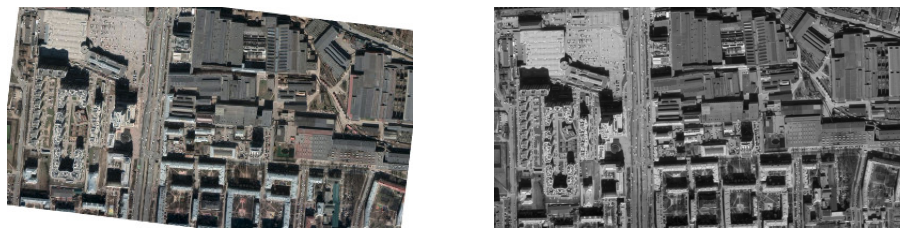

In [24]:
im_rgb = cv2.imread(filename_rgb, cv2.IMREAD_COLOR)
im_chromo = cv2.imread(filename_chromo, cv2.IMREAD_GRAYSCALE)
im_rgb_gray = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)
show_images([im_rgb, im_chromo], color=True)

## Detecting Key Features on both images

In [5]:
MAX_FEATURES = 500
orb = cv2.ORB_create(MAX_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im_rgb_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im_chromo, None)

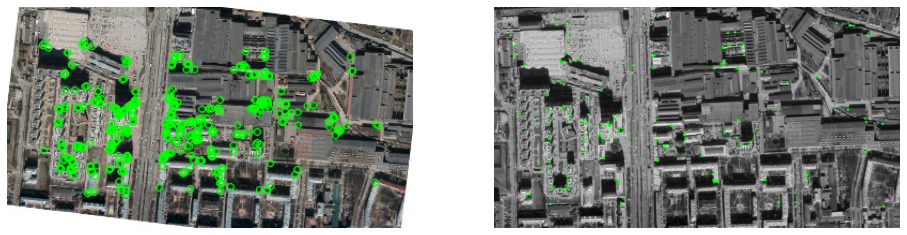

In [6]:
img_keys1 = cv2.drawKeypoints(im_rgb, keypoints1, None, color=(0,255,0), flags=0)
img_keys2 = cv2.drawKeypoints(im_chromo, keypoints2, None, color=(0,255,0), flags=0)
show_images([img_keys1, img_keys2])

## Matching Key Features and choosing the best ones

In [7]:
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors1, descriptors2, None)
matches = list(matches)
matches.sort(key=lambda x: x.distance, reverse=False)

GOOD_MATCH_PERCENT = 0.15
num_good_matches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:num_good_matches]

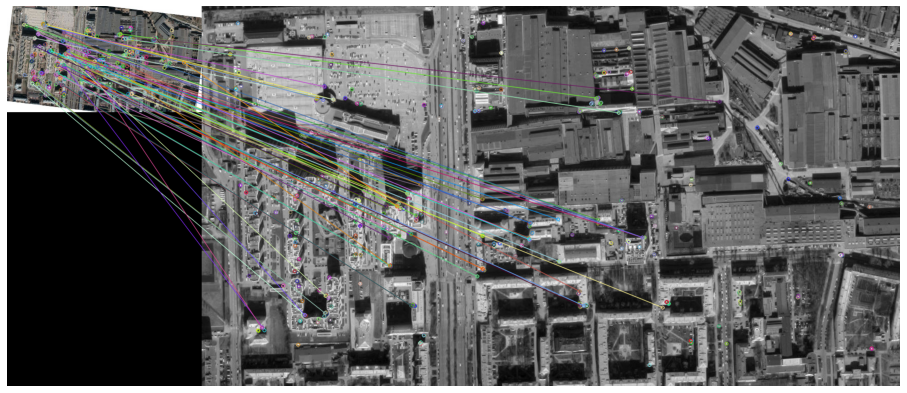

In [27]:
# Draw top matches
im_matches = cv2.drawMatches(im_rgb, keypoints1, im_chromo, keypoints2, matches, None)

plt.figure(figsize=(16, 8))
rgb_image = cv2.cvtColor(im_matches, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
plt.axis('off');

## Extracting coordinates of the matching features

In [9]:
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

## Finding homography based on the features 

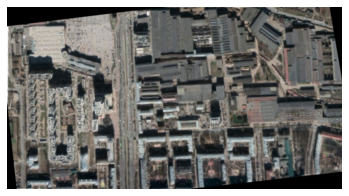

In [28]:
H, mask = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)

height, width = im_chromo.shape
im_rgb_aligned = cv2.warpPerspective(im_rgb, H, (width, height))

show_image(im_rgb_aligned)

## Applying a pan-sharping technique 

#### The technique is quite simple: as in `HSV` color space the `Value` is quite similar to the image in `Grayscale`, let's convert the image to `HSV` and replace the `V` channel with the given `Grayscale` channel with high resolution.

In [20]:
im_hsv = cv2.cvtColor(im_rgb_aligned, cv2.COLOR_BGR2HSV)
im_hsv[:,:,2] = im_chromo
im_rgb_high_resolution = cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR)

## Before pan-sharping

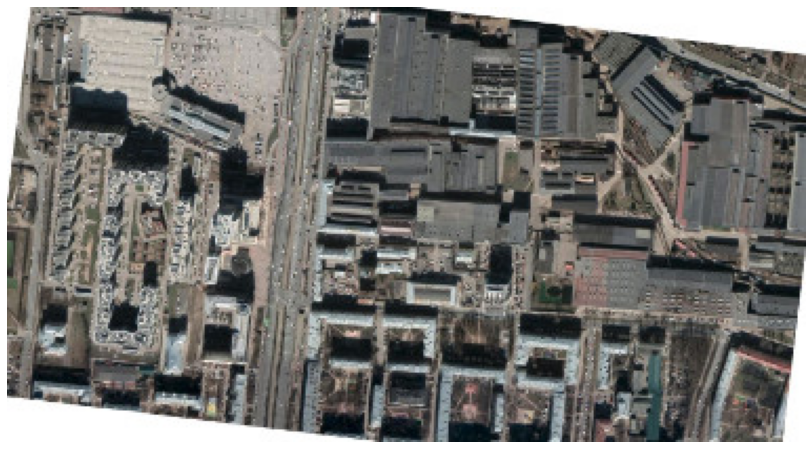

In [21]:
plt.figure(figsize=(16, 8))
rgb_image = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
plt.axis('off');

## After pan-sharping

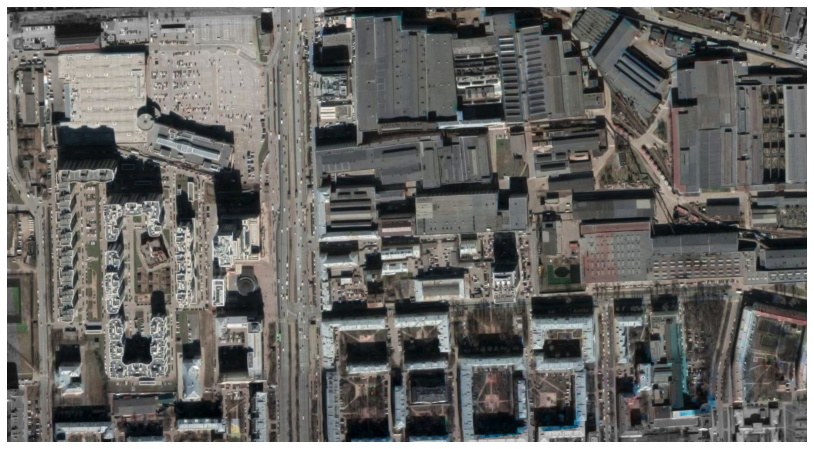

In [22]:
plt.figure(figsize=(16, 8))
rgb_image = cv2.cvtColor(im_rgb_high_resolution, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
plt.axis('off');